In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffusers import FlaxStableDiffusionXLPipeline
import jax.numpy as jnp


pipe, params = FlaxStableDiffusionXLPipeline.from_pretrained(
    "nev/lcm-sdxl-pt",
    from_pt=True,
    dtype=jnp.bfloat16
)

/home/neverix/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 96667.70it/s]


/home/neverix/.cache/huggingface/hub/models--nev--lcm-sdxl-pt/snapshots/b433f29ce22e6ca1d35137d7458749a715f23b97/unet
/home/neverix/.cache/huggingface/hub/models--nev--lcm-sdxl-pt/snapshots/b433f29ce22e6ca1d35137d7458749a715f23b97/vae


In [7]:
import jax
print(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [4]:
dtype = jnp.bfloat16
params = jax.tree_util.tree_map(lambda x: x.astype(dtype), params)

In [5]:
from flax.training.common_utils import shard
from flax.jax_utils import replicate
import numpy as np


p_params = replicate(params)

def create_key(seed=0):
    return jax.random.PRNGKey(seed)

rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

do_jit = True

def generate(prompt_ids):
    images = pipe(
        prompt_ids if do_jit else prompt_ids[0],
        p_params if do_jit else params,
        rng if do_jit else rng[0],
        num_inference_steps=1,
        # neg_prompt_ids=neg_prompt_ids if do_jit else neg_prompt_ids[0],
        guidance_scale = 1.0,
        jit=do_jit,
    ).images
    images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
    return pipe.numpy_to_pil(np.array(images))

/home/neverix/.pyenv/versions/3.12.0/lib/python3.12/site-packages/diffusers/pipelines/pipeline_flax_utils.py:593: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


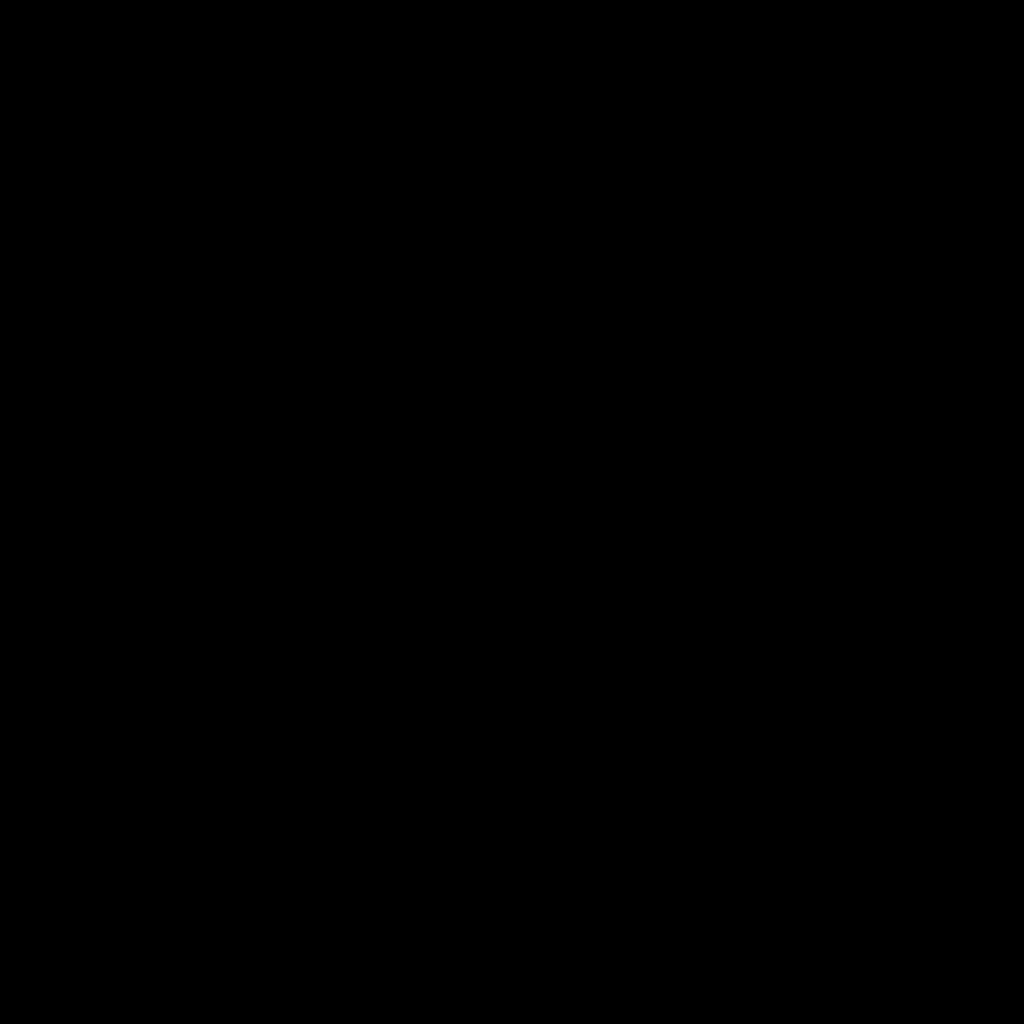

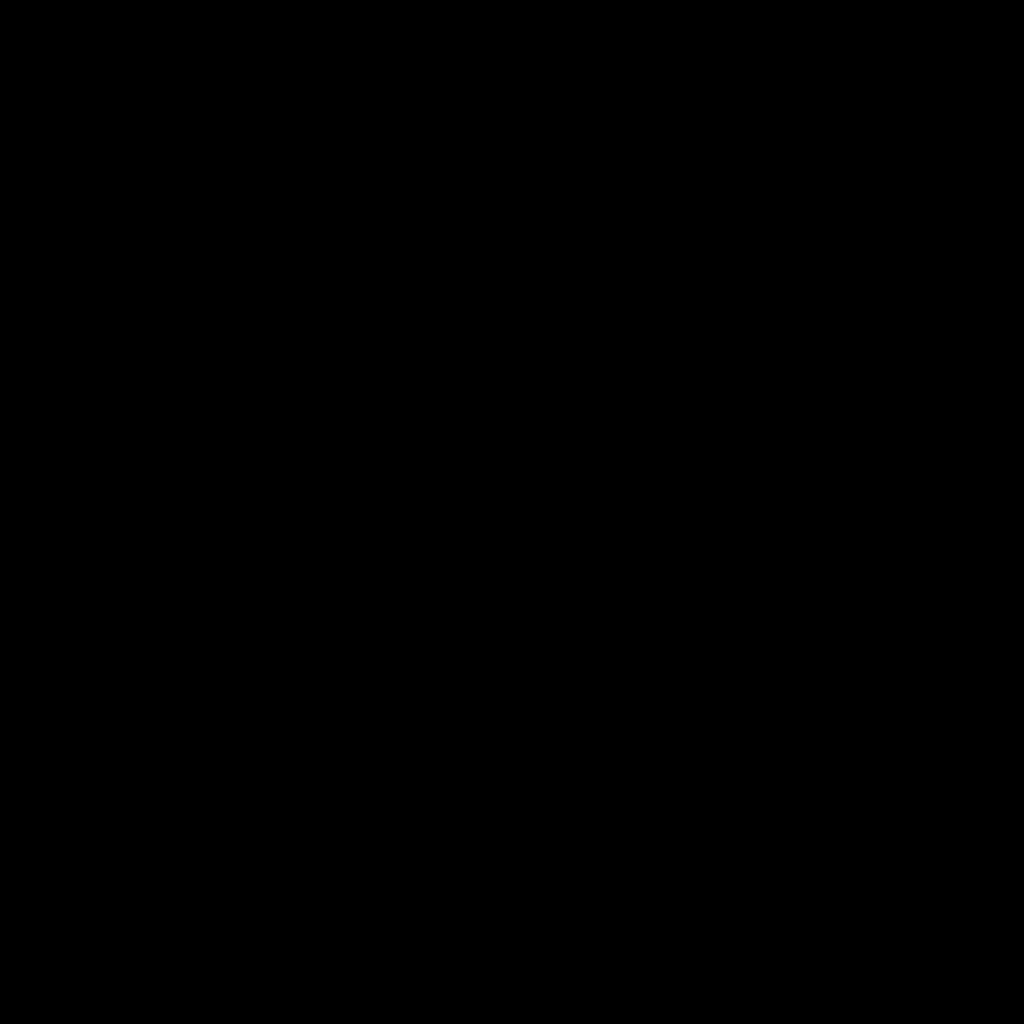

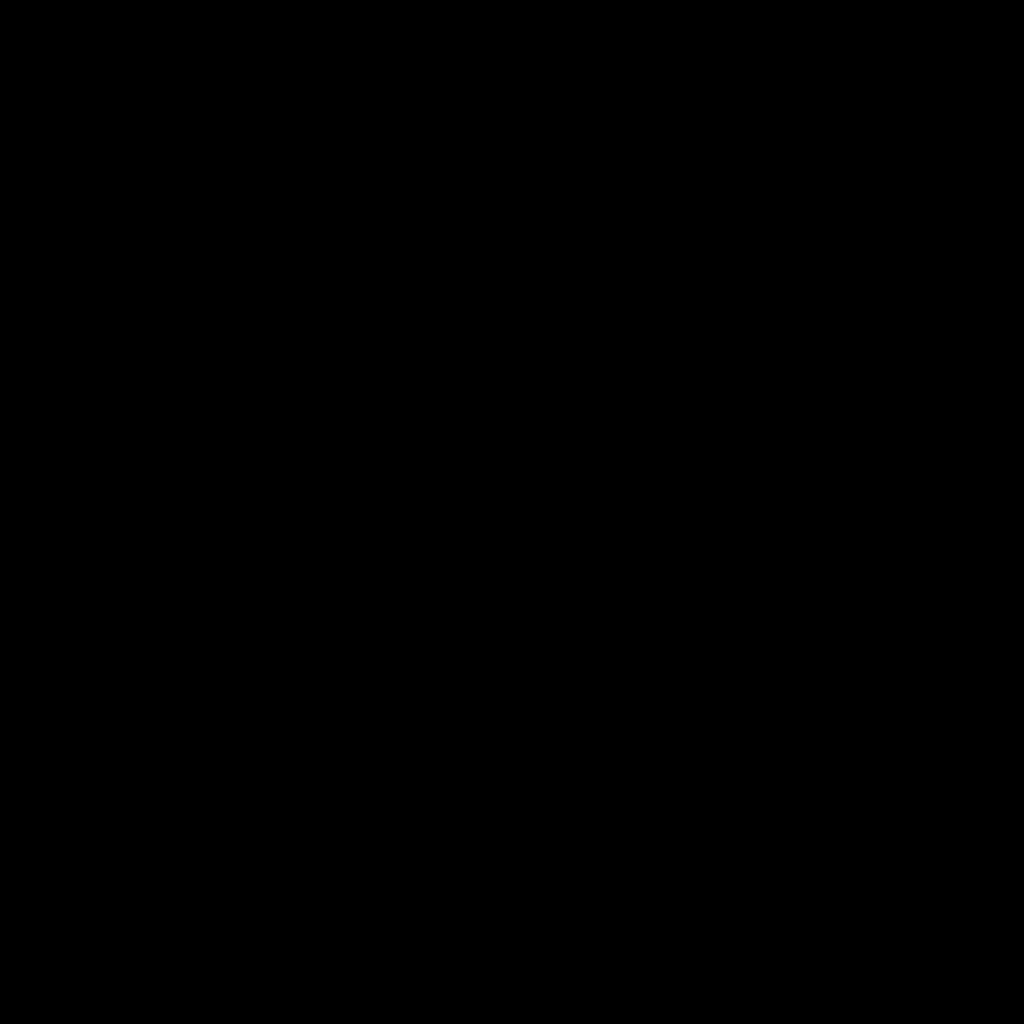

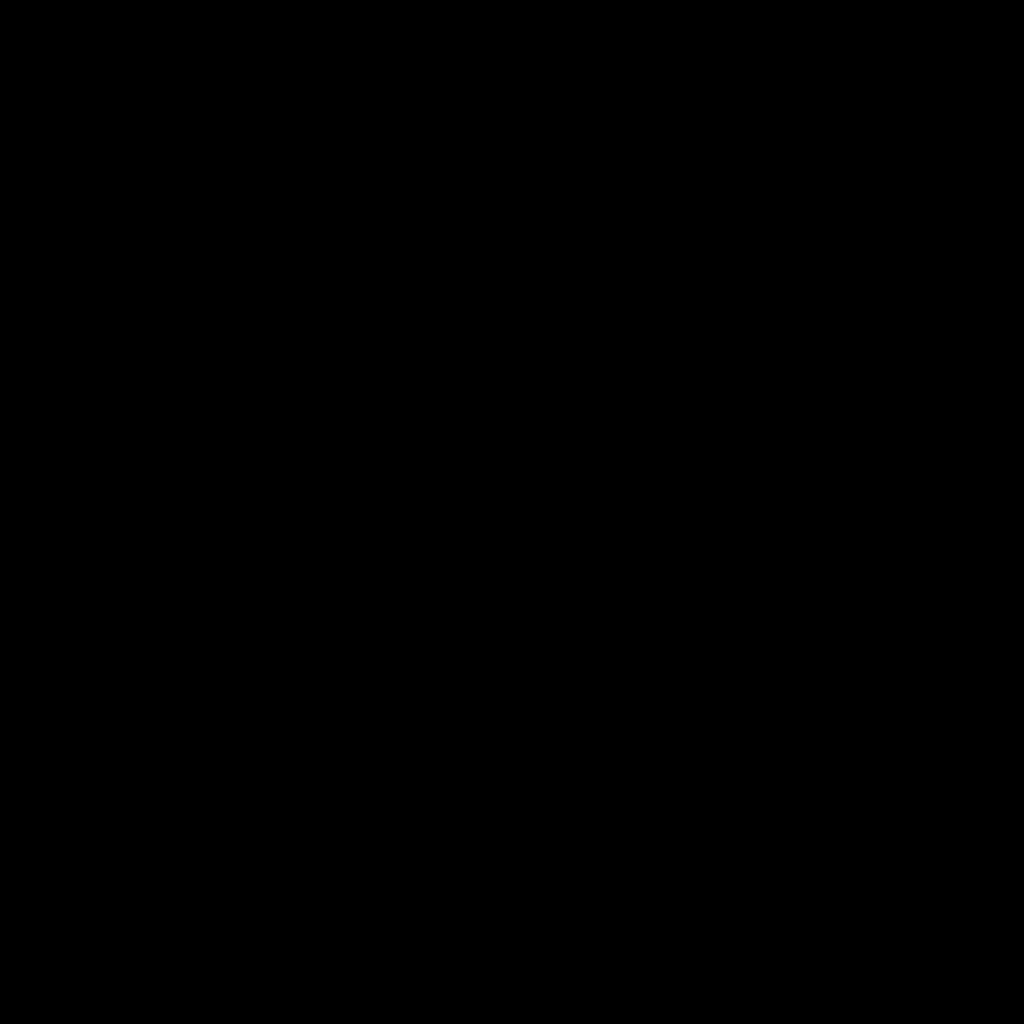

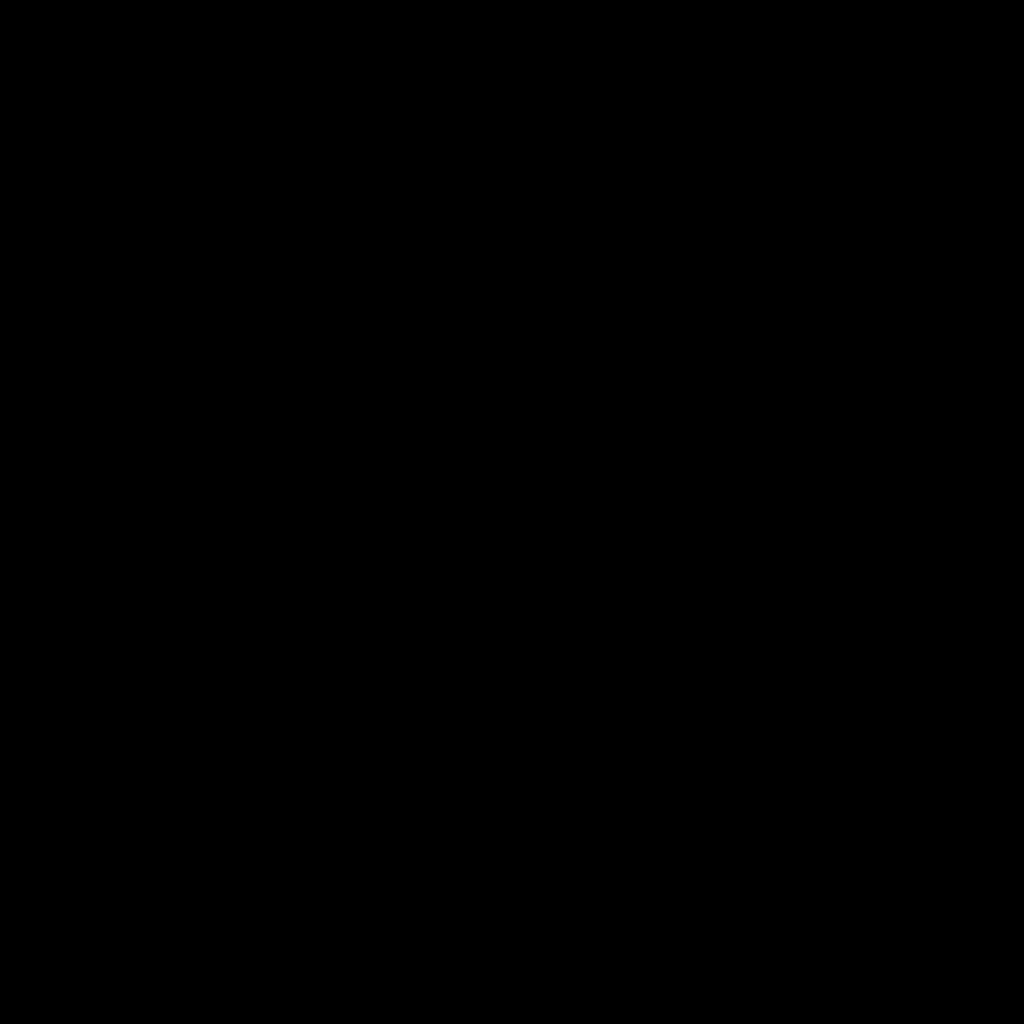

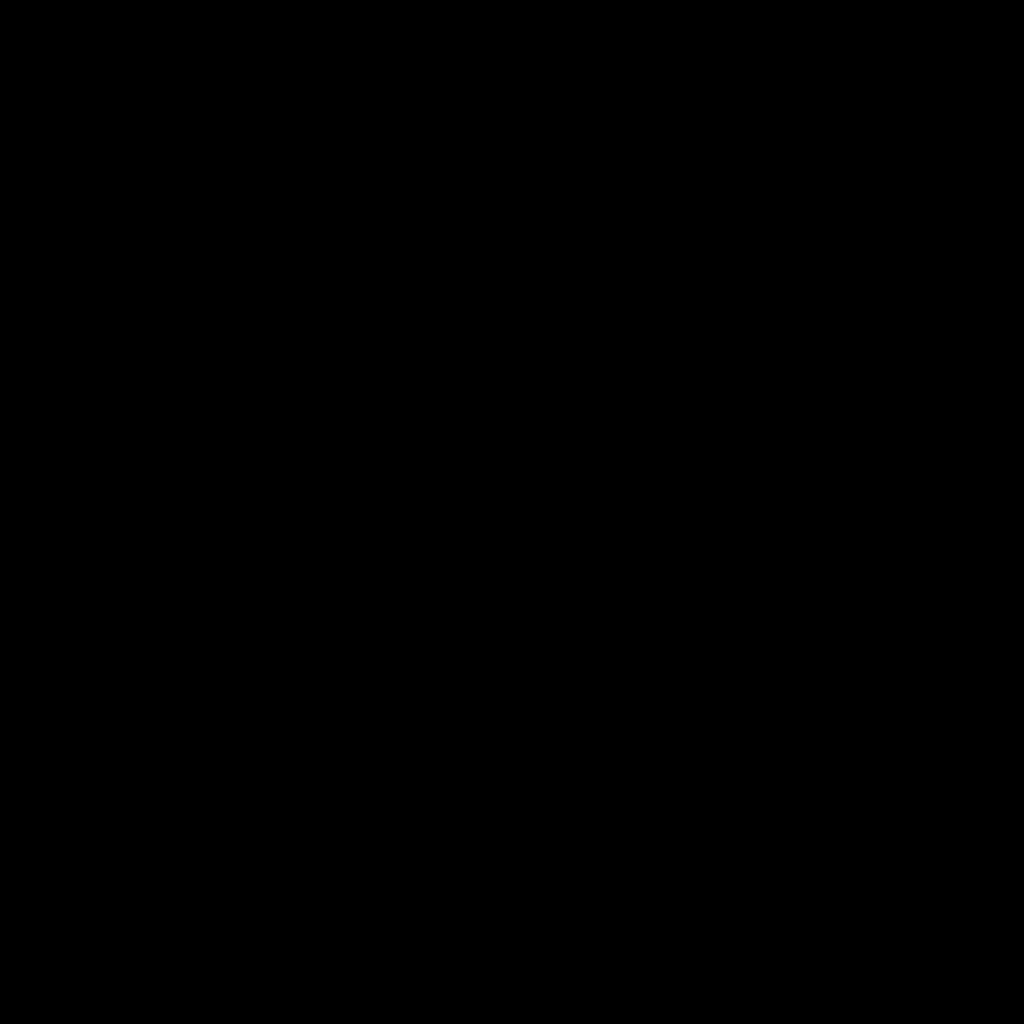

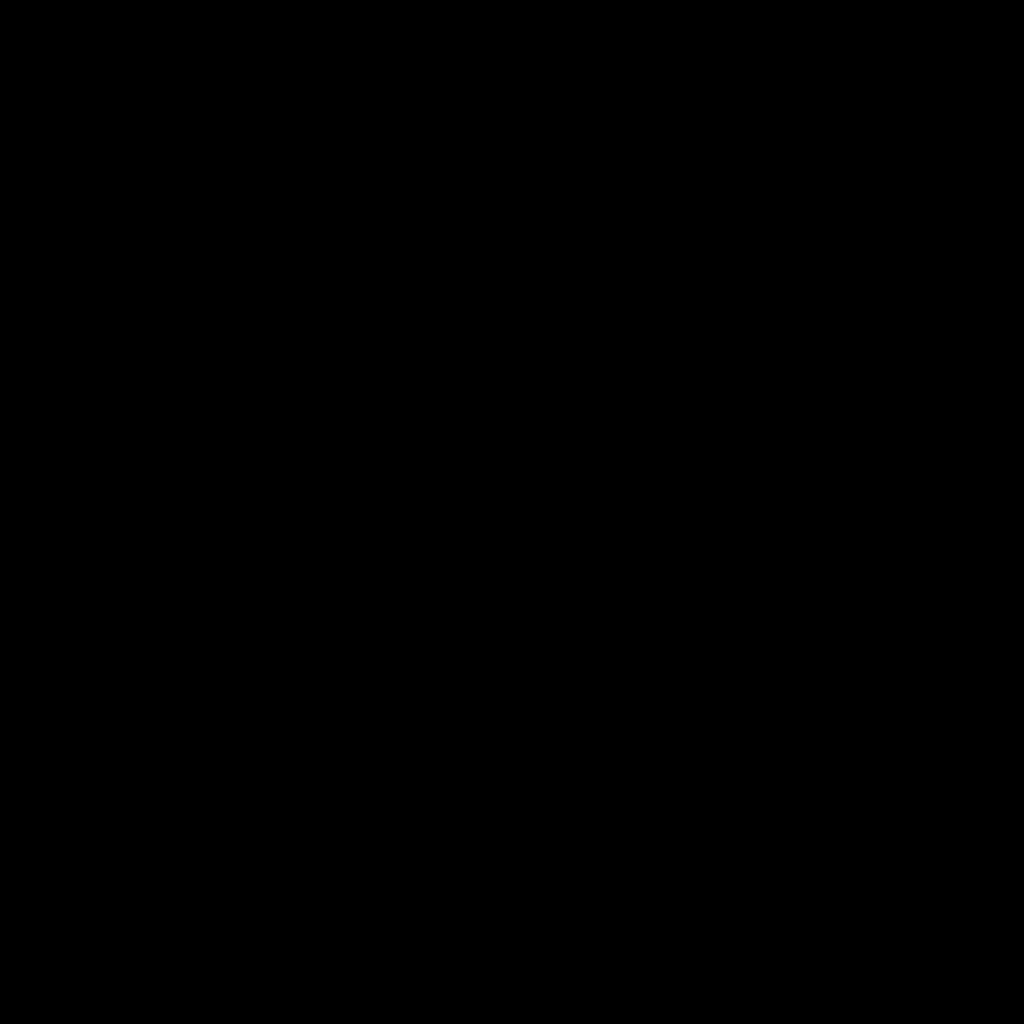

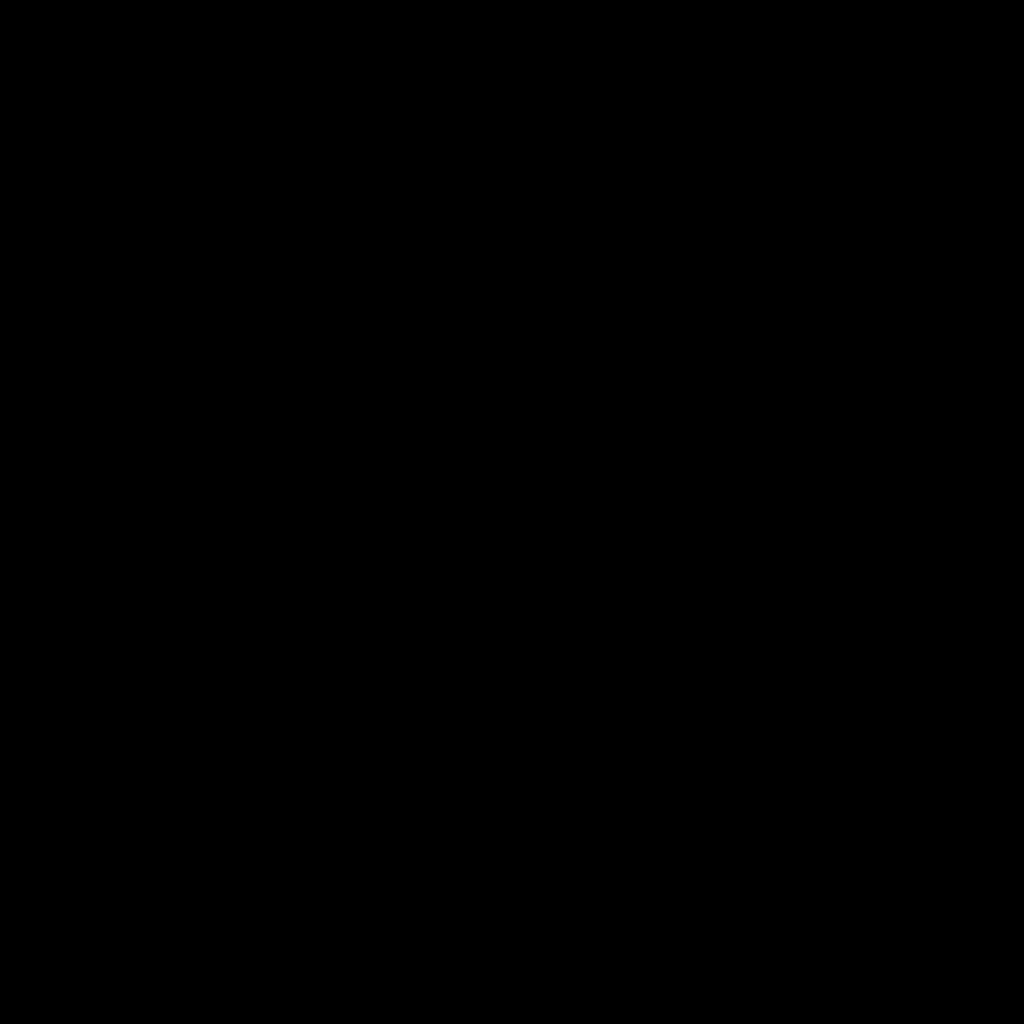

In [6]:
imgs_per_device = 1

prompt = "a cat"
prompts = [prompt] * jax.device_count() * imgs_per_device
prompt_ids = pipe.prepare_inputs(prompts)

prompt_ids = shard(prompt_ids)

for u in generate(prompt_ids):
    display(u)